# Análisis preliminar de los datos:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from wordcloud import WordCloud
from collections import Counter
from sklearn.decomposition import PCA
import re
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
color_palette = sns.color_palette()

2025-04-14 15:12:15.427177: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-14 15:12:15.445767: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-14 15:12:15.595085: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-14 15:12:15.730554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744657935.847905  142717 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744657935.87

# Entrenamiento modelos:

Creamos el dataset df_final que contendrá toda la información: interacción de los tweets, sentiment analysis, word embedding y promedios ponderados por interacción

In [6]:
df = pd.read_csv("../data/features_dataset.csv")
df_encuestas = pd.read_csv("../data/encuestas.csv")

In [10]:
df["date"] = pd.to_datetime(df["date"])
df_encuestas["date"] = pd.to_datetime(df_encuestas["date"])
# Usamos el día domingo como inicio de semana (CADEM sale el domingo):
df["week_start"] = df["date"] - pd.to_timedelta((df["date"].dt.weekday + 1) % 7, unit="D")
df_encuestas["week_start"] = df_encuestas["date"] - pd.to_timedelta((df_encuestas["date"].dt.weekday + 1) % 7, unit="D")
df_final = df.merge(df_encuestas[["week_start", "aprobacion_boric"]], on="week_start", how="left")
df_final = df_final.sort_values("date").dropna()

# Agregamos variables de rezago y rolling:
df_final["approval_rolling_7d"] = df_final["aprobacion_boric"].rolling(window=7, min_periods=7).mean()
df_final["approval_lag_7d"] = df_final["aprobacion_boric"].shift(1)

for lag in range(1, 8):
    for var in ["score_positive", "score_negative", "score_neutral"]:
        df_final[f"{var}_lag_{lag}"] = df_final[var].shift(lag)

df_final['score_negative_rolling7'] = df_final['score_negative'].rolling(window=7, min_periods=3).mean()
df_final['score_negative_rolling3'] = df_final['score_negative'].rolling(window=3, min_periods=3).mean()
df_final['sentiment_net'] = df_final['score_positive'] - df_final['score_negative']
df_final['sentiment_net_rolling7'] = df_final['sentiment_net'].rolling(window=7, min_periods=3).mean()

df_final = df_final.dropna().reset_index(drop=True)

# Escalamos y preparamos datos de entrenamiento:
cols_to_scale = ['retweetCount', 'replyCount', 'likeCount', 'quoteCount']
scaler_social = MinMaxScaler()
df_final[cols_to_scale] = scaler_social.fit_transform(df_final[cols_to_scale])

df_model = df_final.dropna(subset=top_vars + [target]).copy()
df_model = df_model.sort_values("date").reset_index(drop=True)

X_top = df_model[top_vars]
y = df_model[target]
fechas = df_model["date"]

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_top)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

split_idx = int(len(df_model) * 0.8)

X_train = X_scaled[:split_idx]
X_test = X_scaled[split_idx:]
y_train = y_scaled[:split_idx]
y_test = y_scaled[split_idx:]
fechas_train = fechas[:split_idx]
fechas_test = fechas[split_idx:]

KeyError: 'aprobacion_boric'

In [78]:
df_final.head()

,date,score_positive,score_negative,score_neutral,retweetCount,replyCount,likeCount,quoteCount,robertuito_0,robertuito_1,...,score_positive_lag_6,score_negative_lag_6,score_neutral_lag_6,score_positive_lag_7,score_negative_lag_7,score_neutral_lag_7,score_negative_rolling7,score_negative_rolling3,sentiment_net,sentiment_net_rolling7
0,2022-03-20,0.025140,0.653711,0.321149,0.086775,0.018609,0.024285,0.045833,0.642830,0.913833,...,0.044447,0.556187,0.399367,0.068027,0.426942,0.505030,0.528101,0.584041,-0.628571,-0.419191
1,2022-03-21,0.358458,0.196829,0.444713,0.028667,0.180507,0.024696,0.262500,0.135075,0.444441,...,0.025492,0.825355,0.149153,0.044447,0.556187,0.399367,0.476765,0.572186,0.161628,-0.322995
2,2022-03-22,0.184142,0.432754,0.383104,0.043291,0.076297,0.053377,0.055903,0.386215,0.442125,...,0.114029,0.470782,0.415189,0.025492,0.825355,0.149153,0.420679,0.427765,-0.248612,-0.244245
3,2022-03-23,0.156160,0.432733,0.411107,0.015377,0.049017,0.032907,0.028037,0.186812,0.645427,...,0.243527,0.092264,0.664210,0.114029,0.470782,0.415189,0.415243,0.354105,-0.276573,-0.232791
4,2022-03-24,0.156160,0.432733,0.411107,0.015377,0.049017,0.032907,0.028037,0.186812,0.645427,...,0.297204,0.232395,0.470401,0.243527,0.092264,0.664210,0.463882,0.432740,-0.276573,-0.293911


## Random Forest:

Comenzamos con un modelo de Random Forest.

In [79]:
modelo_rf = RandomForestRegressor(
    n_estimators=50,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

modelo_rf.fit(X_train, y_train.ravel())
y_pred_rf = modelo_rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"🌲 Random Forest - MAE: {mae_rf:.2f}, R²: {r2_rf:.2f}")

🌲 Random Forest - MAE: 0.04, R²: 0.83


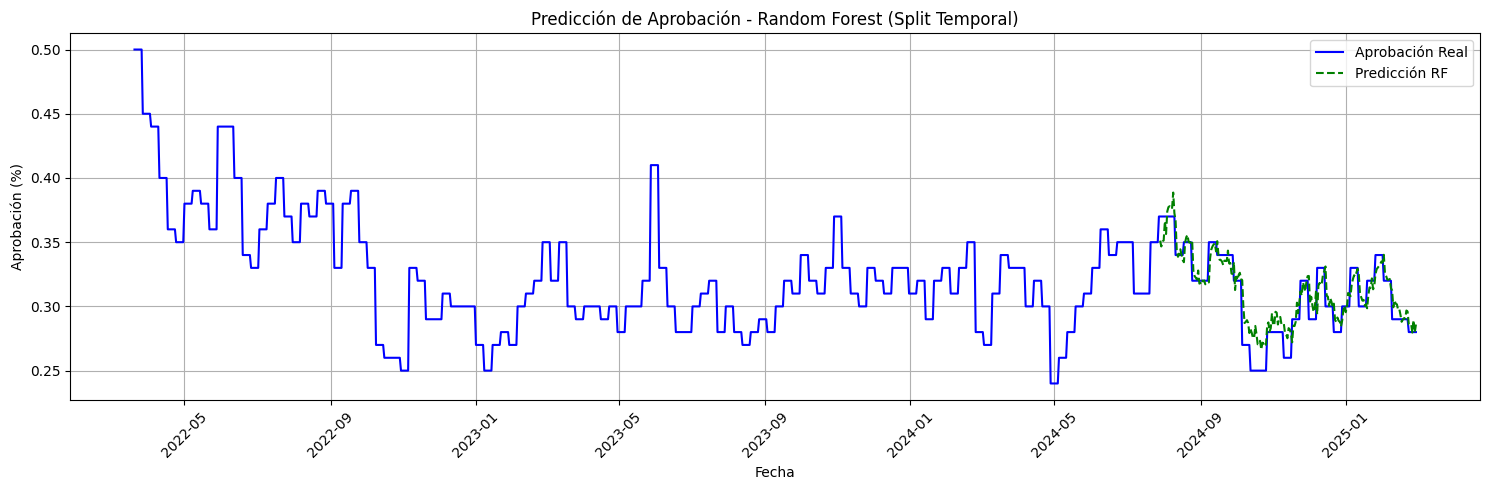

In [80]:
y_test_real_rf = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_real_rf = scaler_y.inverse_transform(y_pred_rf.reshape(-1, 1)).flatten()
y_real_total = scaler_y.inverse_transform(y_scaled.reshape(-1, 1)).flatten()

df_plot = pd.DataFrame({
    "Fecha": fechas.reset_index(drop=True),
    "Aprobación Real": y_real_total,
    "Predicción RF": np.nan
})

# Asignar predicciones solo en las fechas de test
df_plot.loc[fechas_test.index, "Predicción RF"] = y_pred_real_rf

plt.figure(figsize=(15, 5))
plt.plot(df_plot['Fecha'], df_plot['Aprobación Real'], linestyle='-', color='blue', label='Aprobación Real')
plt.plot(df_plot['Fecha'], df_plot['Predicción RF'], linestyle='--', color='green', label='Predicción RF')

plt.title('Predicción de Aprobación - Random Forest (Split Temporal)')
plt.xlabel('Fecha')
plt.ylabel('Aprobación (%)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Veamos la calidad de la predicción analizando la calidad o importancia de las variables predictoras:

In [81]:
importancias = pd.DataFrame({
    'Variable': X_top.columns,
    'Importancia': modelo_rf.feature_importances_
}).sort_values(by='Importancia', ascending=False)

# === 2. Mostrar las top 15 variables ===
print("🎯 Variables más importantes (top 15):")
print(importancias.head(15))

🎯 Variables más importantes (top 15):
                   Variable  Importancia
0           approval_lag_7d     0.408668
1       approval_rolling_7d     0.328558
2    sentiment_net_rolling7     0.043881
3   score_negative_rolling7     0.041112
9            robertuito_573     0.023796
4            robertuito_214     0.018104
8      score_negative_lag_6     0.017562
5      score_negative_lag_4     0.016951
12           robertuito_190     0.016714
11           robertuito_125     0.015261
14            robertuito_18     0.015195
7            robertuito_474     0.014609
10           robertuito_530     0.014324
13           robertuito_324     0.012637
6      score_negative_lag_3     0.012627


🌲 Random Forest con X_top - MAE: 0.0091, R²: 0.8526


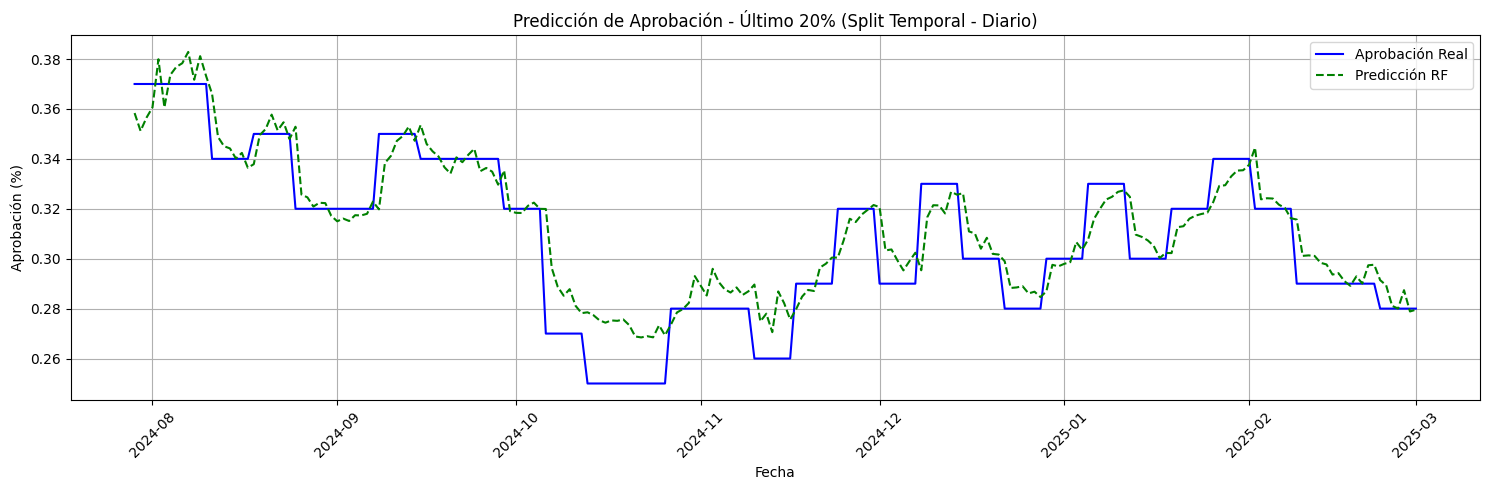

In [83]:
top_vars = importancias.head(15)['Variable'].tolist()
target = 'aprobacion_boric'

df_model = df_final.dropna(subset=top_vars + [target]).copy()
df_model = df_model.sort_values("date").reset_index(drop=True)

X_top = df_model[top_vars]
y = df_model[target]
fechas = df_model["date"].reset_index(drop=True)

# === 2. Escalar ===
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_top)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# === 3. Split temporal (80/20) ===
split_idx = int(len(df_model) * 0.8)
X_train = X_scaled[:split_idx]
X_test = X_scaled[split_idx:]
y_train = y_scaled[:split_idx]
y_test = y_scaled[split_idx:]
fechas_train = fechas[:split_idx]
fechas_test = fechas[split_idx:]

# === 4. Entrenar modelo ===
modelo_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
modelo_rf.fit(X_train, y_train)
y_pred = modelo_rf.predict(X_test)

# === 5. Desescalar ===
y_test_real_rf = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_real_rf = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# === 6. Métricas ===
mae = mean_absolute_error(y_test_real_rf, y_pred_real_rf)
r2 = r2_score(y_test_real_rf, y_pred_real_rf)
print(f"🌲 Random Forest con X_top - MAE: {mae:.4f}, R²: {r2:.4f}")

# === 7. Gráfico del 20% final ===
df_plot = pd.DataFrame({
    "Fecha": fechas_test,
    "Aprobación Real": y_test_real_rf,
    "Predicción RF": y_pred_real_rf
}).sort_values("Fecha")  # importante para graficar bien

plt.figure(figsize=(15, 5))
plt.plot(df_plot["Fecha"], df_plot["Aprobación Real"], color="blue", label="Aprobación Real")
plt.plot(df_plot["Fecha"], df_plot["Predicción RF"], linestyle="--", color="green", label="Predicción RF")
plt.title("Predicción de Aprobación - Último 20% (Split Temporal - Diario)")
plt.xlabel("Fecha")
plt.ylabel("Aprobación (%)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## XGBoost:

/home/pollodk/.pyenv/versions/3.10.6/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


⚡ XGBoost - MAE: 0.0062, R²: 0.8970


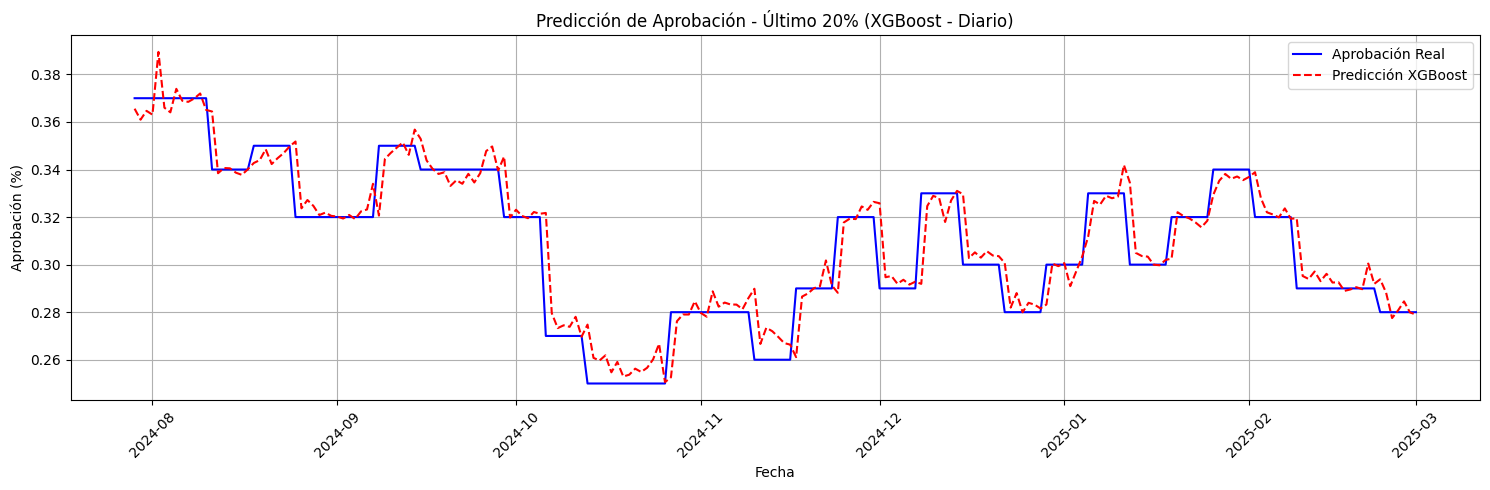

In [84]:
top_vars = importancias.head(15)['Variable'].tolist()
target = 'aprobacion_boric'

df_model = df_final.dropna(subset=top_vars + [target]).copy()
df_model = df_model.sort_values("date").reset_index(drop=True)

X_top = df_model[top_vars]
y = df_model[target]
fechas = df_model["date"].reset_index(drop=True)

# === 2. Escalar ===
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_top)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# === 3. Split temporal (80/20) ===
split_idx = int(len(df_model) * 0.8)
X_train = X_scaled[:split_idx]
X_test = X_scaled[split_idx:]
y_train = y_scaled[:split_idx]
y_test = y_scaled[split_idx:]
fechas_train = fechas[:split_idx]
fechas_test = fechas[split_idx:]

# === 4. Entrenar modelo XGBoost ===
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror", 
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=20,
    verbose=False
)

# === 5. Predicción y desescalado ===
y_pred_xgb = xgb_model.predict(X_test)
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_real = scaler_y.inverse_transform(y_pred_xgb.reshape(-1, 1)).flatten()

# === 6. Métricas ===
mae_xgb = mean_absolute_error(y_test_real, y_pred_real)
r2_xgb = r2_score(y_test_real, y_pred_real)
print(f"⚡ XGBoost - MAE: {mae_xgb:.4f}, R²: {r2_xgb:.4f}")

# === 7. Gráfico del 20% final (diario) ===
df_plot = pd.DataFrame({
    "Fecha": fechas_test,
    "Aprobación Real": y_test_real,
    "Predicción XGBoost": y_pred_real
}).sort_values("Fecha")  # importante para mantener orden temporal

plt.figure(figsize=(15, 5))
plt.plot(df_plot["Fecha"], df_plot["Aprobación Real"], color="blue", label="Aprobación Real")
plt.plot(df_plot["Fecha"], df_plot["Predicción XGBoost"], linestyle="--", color="red", label="Predicción XGBoost")

plt.title("Predicción de Aprobación - Último 20% (XGBoost - Diario)")
plt.xlabel("Fecha")
plt.ylabel("Aprobación (%)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## KNN:

📊 KNN - MAE: 0.0133, R²: 0.7216


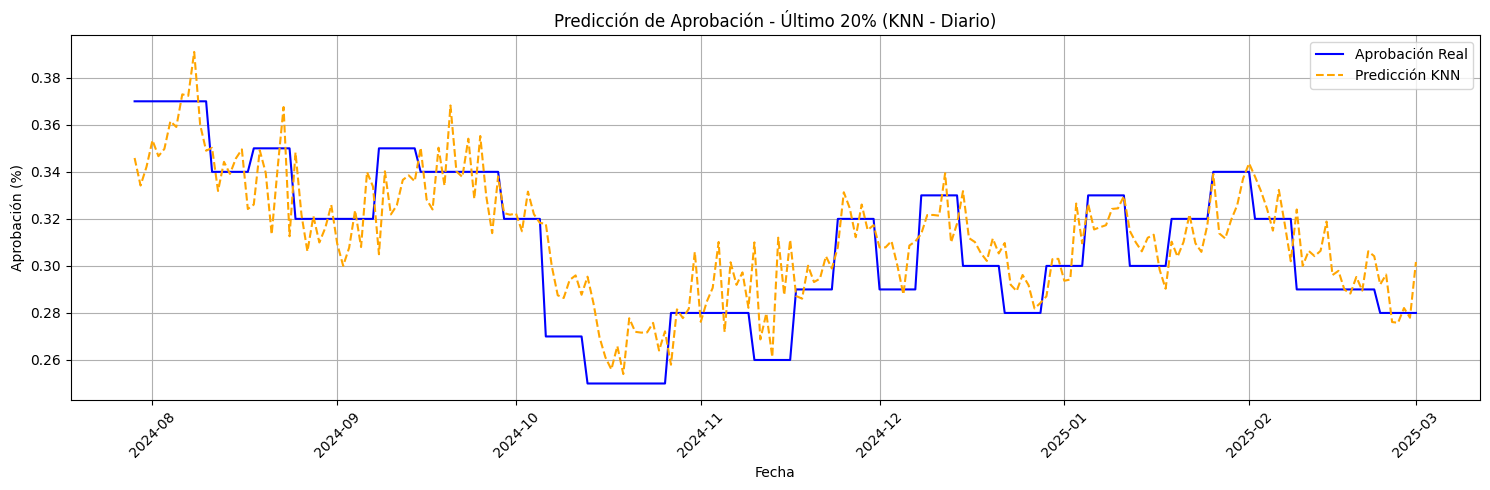

In [85]:
from sklearn.neighbors import KNeighborsRegressor

top_vars = importancias.head(15)['Variable'].tolist()
target = 'aprobacion_boric'

df_model = df_final.dropna(subset=top_vars + [target]).copy()
df_model = df_model.sort_values("date").reset_index(drop=True)

X_top = df_model[top_vars]
y = df_model[target]
fechas = df_model["date"].reset_index(drop=True)

# === 2. Escalar features y target ===
scaler_X = StandardScaler()  # KNN suele funcionar mejor con StandardScaler
X_scaled = scaler_X.fit_transform(X_top)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# === 3. Split temporal (80/20) ===
split_idx = int(len(df_model) * 0.8)
X_train = X_scaled[:split_idx]
X_test = X_scaled[split_idx:]
y_train = y_scaled[:split_idx]
y_test = y_scaled[split_idx:]
fechas_train = fechas[:split_idx]
fechas_test = fechas[split_idx:]

# === 4. Entrenar modelo KNN ===
knn_model = KNeighborsRegressor(
    n_neighbors=5,
    weights='distance',
    metric='euclidean'
)
knn_model.fit(X_train, y_train)

# === 5. Predicción y desescalado ===
y_pred_knn = knn_model.predict(X_test)
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_real = scaler_y.inverse_transform(y_pred_knn.reshape(-1, 1)).flatten()

# === 6. Métricas ===
mae_knn = mean_absolute_error(y_test_real, y_pred_real)
r2_knn = r2_score(y_test_real, y_pred_real)
print(f"📊 KNN - MAE: {mae_knn:.4f}, R²: {r2_knn:.4f}")

# === 7. Gráfico del 20% final (diario) ===
df_plot = pd.DataFrame({
    "Fecha": fechas_test,
    "Aprobación Real": y_test_real,
    "Predicción KNN": y_pred_real
}).sort_values("Fecha")

plt.figure(figsize=(15, 5))
plt.plot(df_plot["Fecha"], df_plot["Aprobación Real"], color="blue", label="Aprobación Real")
plt.plot(df_plot["Fecha"], df_plot["Predicción KNN"], linestyle="--", color="orange", label="Predicción KNN")

plt.title("Predicción de Aprobación - Último 20% (KNN - Diario)")
plt.xlabel("Fecha")
plt.ylabel("Aprobación (%)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## MLP:

/home/pollodk/.pyenv/versions/3.10.6/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
🤖 MLP - MAE: 0.0079, R²: 0.8766


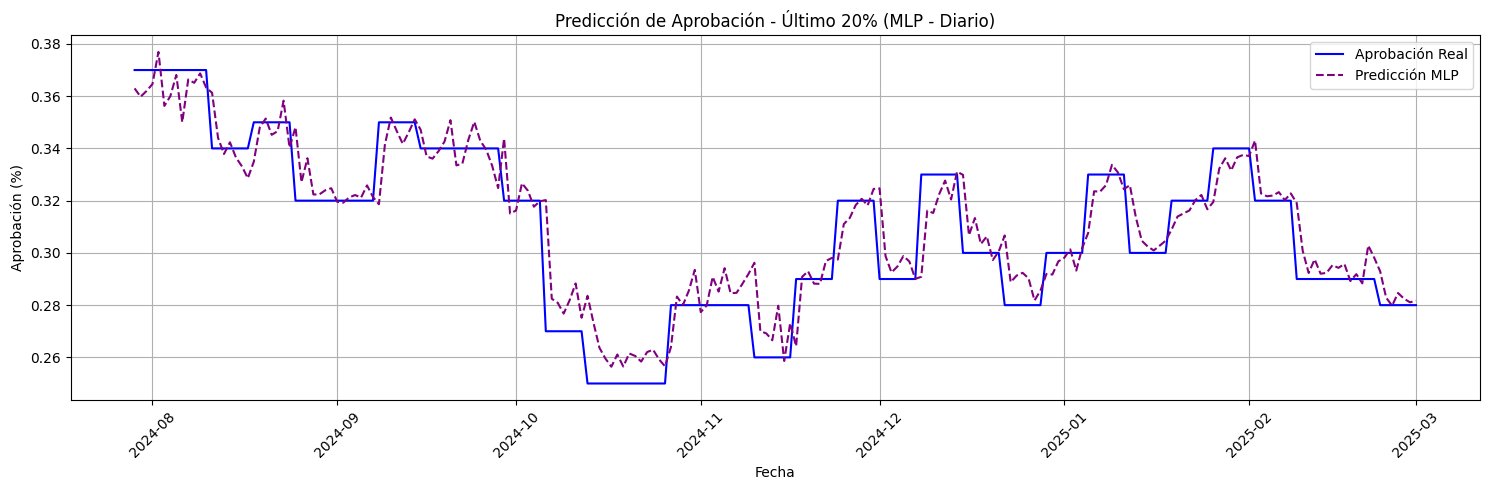

In [86]:
# === 1. Preparar datos ===
top_vars = importancias.head(15)['Variable'].tolist()
target = 'aprobacion_boric'

df_model = df_final.dropna(subset=top_vars + [target]).copy()
df_model = df_model.sort_values("date").reset_index(drop=True)

X_top = df_model[top_vars]
y = df_model[target]
fechas = df_model["date"].reset_index(drop=True)

# === 2. Escalamiento ===
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_top)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# === 3. Split temporal (80/20) ===
split_idx = int(len(df_model) * 0.8)
X_train = X_scaled[:split_idx]
X_test = X_scaled[split_idx:]
y_train = y_scaled[:split_idx]
y_test = y_scaled[split_idx:]
fechas_train = fechas[:split_idx]
fechas_test = fechas[split_idx:]

# === 4. Definir y entrenar modelo MLP ===
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # salida para regresión
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=0
)

# === 5. Predicción y desescalado ===
y_pred_mlp = model.predict(X_test).flatten()
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_real = scaler_y.inverse_transform(y_pred_mlp.reshape(-1, 1)).flatten()

# === 6. Métricas ===
mae_mlp = mean_absolute_error(y_test_real, y_pred_real)
r2_mlp = r2_score(y_test_real, y_pred_real)
print(f"🤖 MLP - MAE: {mae_mlp:.4f}, R²: {r2_mlp:.4f}")

# === 7. Gráfico del 20% final (diario) ===
df_plot = pd.DataFrame({
    "Fecha": fechas_test,
    "Aprobación Real": y_test_real,
    "Predicción MLP": y_pred_real
}).sort_values("Fecha")

plt.figure(figsize=(15, 5))
plt.plot(df_plot["Fecha"], df_plot["Aprobación Real"], color="blue", label="Aprobación Real")
plt.plot(df_plot["Fecha"], df_plot["Predicción MLP"], linestyle="--", color="purple", label="Predicción MLP")

plt.title("Predicción de Aprobación - Último 20% (MLP - Diario)")
plt.xlabel("Fecha")
plt.ylabel("Aprobación (%)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

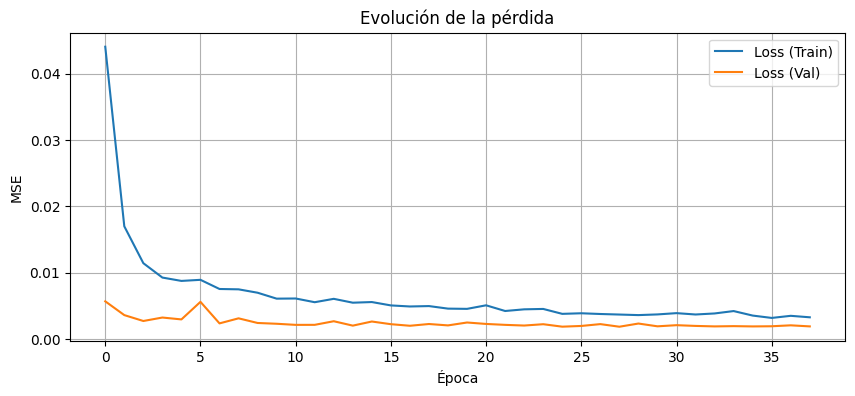

In [67]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Loss (Train)')
plt.plot(history.history['val_loss'], label='Loss (Val)')
plt.title('Evolución de la pérdida')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

## LSTM:

/home/pollodk/.pyenv/versions/3.10.6/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
🔮 LSTM - MAE: 0.0091, R²: 0.8171


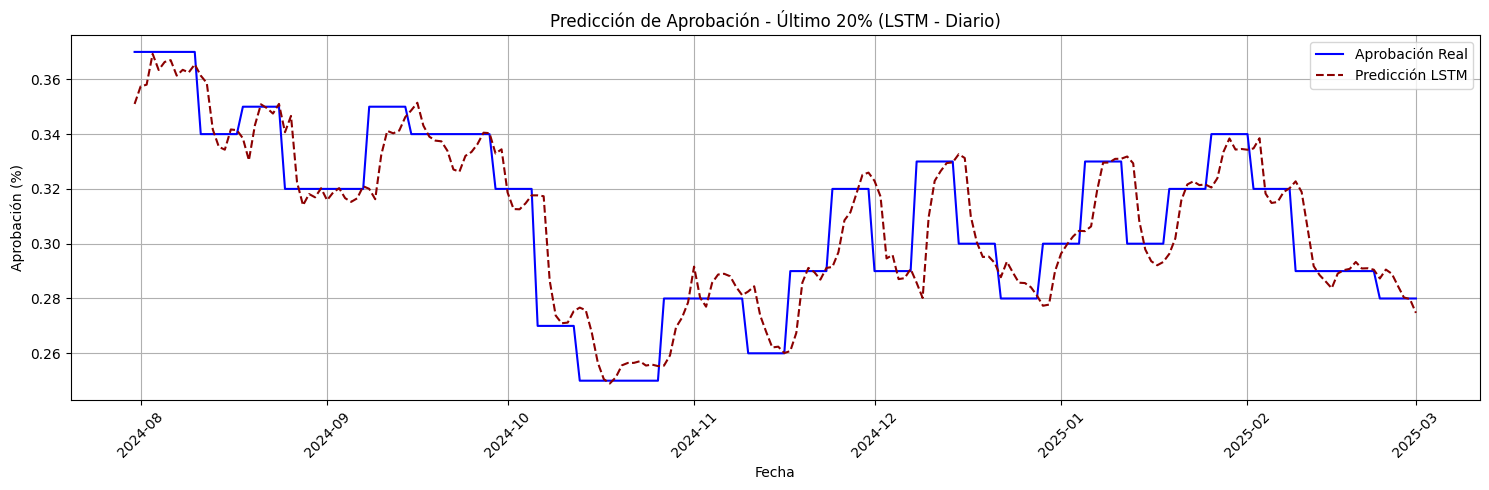

In [87]:
from tensorflow.keras.layers import LSTM, Dense, Dropout

top_vars = importancias.head(15)['Variable'].tolist()
target = 'aprobacion_boric'

df_model = df_final.dropna(subset=top_vars + [target]).copy()
df_model = df_model.sort_values("date").reset_index(drop=True)

X_all = df_model[top_vars].values
y_all = df_model[target].values.reshape(-1, 1)
fechas = df_model["date"].reset_index(drop=True)

# === 2. Escalamiento ===
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_all)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y_all).flatten()

# === 3. Crear secuencias para LSTM ===
def crear_secuencias(X, y, fechas, ventana=10):
    X_seq, y_seq, fechas_seq = [], [], []
    for i in range(ventana, len(X)):
        X_seq.append(X[i-ventana:i])
        y_seq.append(y[i])
        fechas_seq.append(fechas[i])
    return np.array(X_seq), np.array(y_seq), pd.Series(fechas_seq)

lookback = 10
X_seq, y_seq, fechas_seq = crear_secuencias(X_scaled, y_scaled, fechas, ventana=lookback)

# === 4. Split temporal (80/20) ===
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]
fechas_train, fechas_test = fechas_seq[:split_idx], fechas_seq[split_idx:]

# === 5. Definir modelo LSTM ===
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(lookback, X_train.shape[2])),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=0
)

# === 6. Predicción y desescalado ===
y_pred_lstm = model.predict(X_test).flatten()
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_real = scaler_y.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()

# === 7. Métricas ===
mae_lstm = mean_absolute_error(y_test_real, y_pred_real)
r2_lstm = r2_score(y_test_real, y_pred_real)
print(f"🔮 LSTM - MAE: {mae_lstm:.4f}, R²: {r2_lstm:.4f}")

# === 8. Gráfico del 20% final ===
df_plot = pd.DataFrame({
    "Fecha": fechas_test.values,
    "Aprobación Real": y_test_real,
    "Predicción LSTM": y_pred_real
}).sort_values("Fecha")

plt.figure(figsize=(15, 5))
plt.plot(df_plot["Fecha"], df_plot["Aprobación Real"], color="blue", label="Aprobación Real")
plt.plot(df_plot["Fecha"], df_plot["Predicción LSTM"], linestyle="--", color="darkred", label="Predicción LSTM")

plt.title("Predicción de Aprobación - Último 20% (LSTM - Diario)")
plt.xlabel("Fecha")
plt.ylabel("Aprobación (%)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Comparación de resultados:

In [88]:
# Asegúrate de tener los r2_train_X de cada modelo:
r2_train_rf = r2_score(y_train, modelo_rf.predict(X_train))
r2_train_xgb = r2_score(y_train, xgb_model.predict(X_train))
r2_train_knn = r2_score(y_train, knn_model.predict(X_train))
r2_train_mlp = r2_score(y_train, model.predict(X_train).flatten())
r2_train_lstm = r2_score(y_train, model.predict(X_train).flatten())  # Para LSTM

# Crear tabla comparativa
resultados = pd.DataFrame({
    "Modelo": ["Random Forest", "XGBoost", "KNN", "MLP", "LSTM"],
    "MAE Test": [mae_rf, mae_xgb, mae_knn, mae_mlp, mae_lstm],
    "R² Train": [r2_train_rf, r2_train_xgb, r2_train_knn, r2_train_mlp, r2_train_lstm],
    "R² Test": [r2_rf, r2_xgb, r2_knn, r2_mlp, r2_lstm]
})

# Mostrar tabla ordenada por R² Test
resultados = resultados.sort_values(by="R² Test", ascending=False).reset_index(drop=True)
print("📊 Comparación de modelos:")
print(resultados.to_string(index=False))

ValueError: Found array with dim 3. RandomForestRegressor expected <= 2.

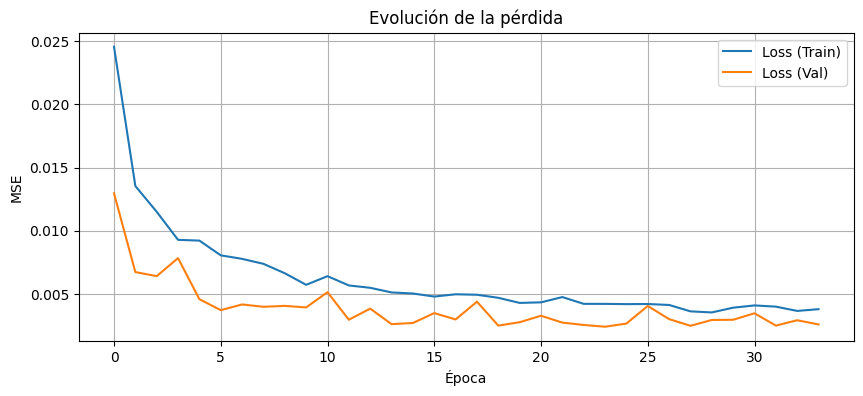

In [95]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Loss (Train)')
plt.plot(history.history['val_loss'], label='Loss (Val)')
plt.title('Evolución de la pérdida')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()